In [3]:
import sys
!{sys.executable} -m pip install pyspark==3.5.0 findspark --prefer-binary

  Using cached pyspark-3.5.0.tar.gz (316.9 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached findspark-2.0.1-py2.py3-none-any.whl.metadata (352 bytes)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
Using cached findspark-2.0.1-py2.py3-none-any.whl (4.4 kB)
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425384 sha256=cc703f0ae424934a8106682482389dfce5912bdb49a0b8c54bf4daac19e89562
  Stored in directory: c:\users\thari\appdata\local\pip\cache\wheels\84\40\20\65eefe766118e0a8f8e385cc3ed6e9eb7241c7e51cfc04c51a
Successfully built pyspark


In [1]:
# ==============================================================================
# BIG DATA ANALYTICS: NASA METEORITE LANDINGS
# ==============================================================================

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log1p, when, count, isnan
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                      RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# --- CELL 2: START SPARK ---
spark = SparkSession.builder \
    .appName("NASA_Meteorite_Project") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"Spark Session Running. Version: {spark.version}")

Spark Session Running. Version: 3.5.0


In [3]:
# --- LOADING & CLEANING ---
print("--- DATA PROCESSING ---")

# 1. Load Data
try:
    df = spark.read.option("header", "true") \
                   .option("inferSchema", "true") \
                   .csv("meteorite-landings.csv")
    print(f"Original Rows: {df.count()}")
except Exception as e:
    print("ERROR: 'Meteorite_Landings.csv' not found.")
    raise e

# 2. Advanced Cleaning (Removing Nulls & 'Null Island' coordinates)
df_clean = df.na.drop(subset=["mass", "reclat", "reclong", "year", "fall"]) \
             .filter((col("mass") > 0) & 
                     (col("reclat") != 0.0) & 
                     (col("reclong") != 0.0))

print(f"Cleaned Rows:  {df_clean.count()}")
df_clean.show(5)

--- DATA PROCESSING ---
Original Rows: 45716
Cleaned Rows:  31688
+--------+---+--------+-----------+--------+----+----+---------+--------+--------------------+
|    name| id|nametype|   recclass|    mass|fall|year|   reclat| reclong|         GeoLocation|
+--------+---+--------+-----------+--------+----+----+---------+--------+--------------------+
|  Aachen|  1|   Valid|         L5|    21.0|Fell|1880|   50.775| 6.08333|(50.775000, 6.083...|
|  Aarhus|  2|   Valid|         H6|   720.0|Fell|1951| 56.18333|10.23333|(56.183330, 10.23...|
|    Abee|  6|   Valid|        EH4|107000.0|Fell|1952| 54.21667|  -113.0|(54.216670, -113....|
|Acapulco| 10|   Valid|Acapulcoite|  1914.0|Fell|1976| 16.88333|   -99.9|(16.883330, -99.9...|
| Achiras|370|   Valid|         L6|   780.0|Fell|1902|-33.16667|  -64.95|(-33.166670, -64....|
+--------+---+--------+-----------+--------+----+----+---------+--------+--------------------+
only showing top 5 rows



In [4]:
# --- FEATURE ENGINEERING ---
print("--- FEATURE ENGINEERING ---")

# A. Log Transformation (Normalize mass)
df_prepared = df_clean.withColumn("log_mass", log1p(col("mass")))

# B. Index Target (Fell/Found -> 0/1)
indexer = StringIndexer(inputCol="fall", outputCol="label")
df_indexed = indexer.fit(df_prepared).transform(df_prepared)

# C. Vector Assembly
feature_cols = ["reclat", "reclong", "log_mass", "year"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
df_assembled = assembler.transform(df_indexed)

# D. Scaling (Standardization)
scaler = StandardScaler(inputCol="raw_features", outputCol="features", 
                        withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_final = scaler_model.transform(df_assembled)

# Split Data
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)
print(f"Training Set: {train_data.count()} | Testing Set: {test_data.count()}")

--- FEATURE ENGINEERING ---
Training Set: 25382 | Testing Set: 6306


--- GENERATING CORRELATION MATRIX ---


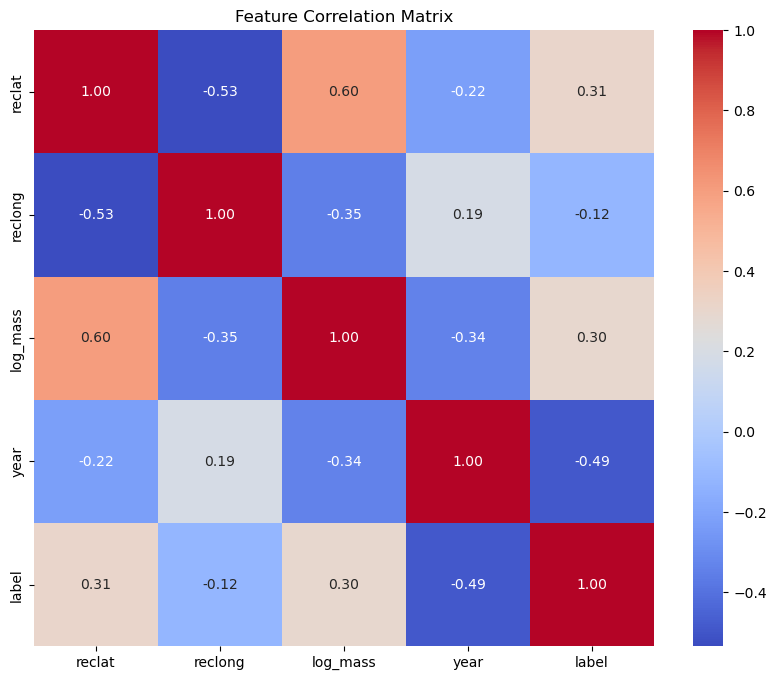

In [5]:
# --- CORRELATION MATRIX ---
print("--- GENERATING CORRELATION MATRIX ---")

# Calculate Correlation
vector_col = "corr_features"
assembler_corr = VectorAssembler(inputCols=feature_cols + ["label"], outputCol=vector_col)
df_corr = assembler_corr.transform(df_indexed)
matrix = Correlation.corr(df_corr, vector_col).head()
corr_array = matrix[0].toArray()

# Plot Heatmap
plt.figure(figsize=(10, 8))
labels = feature_cols + ["label"]
sns.heatmap(corr_array, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=labels, yticklabels=labels)
plt.title("Feature Correlation Matrix")
plt.show()

In [6]:
# --- K-MEANS CLUSTERING ---
print("--- UNSUPERVISED LEARNING ---")

kmeans = KMeans(featuresCol="features", k=5, seed=1)
model_km = kmeans.fit(train_data)
predictions_km = model_km.transform(test_data)

evaluator_km = ClusteringEvaluator()
silhouette = evaluator_km.evaluate(predictions_km)
print(f"K-Means Silhouette Score (k=5): {silhouette:.4f}")

--- UNSUPERVISED LEARNING ---
K-Means Silhouette Score (k=5): 0.5942


In [7]:
# --- MODEL COMPARISON ---
print("--- SUPERVISED LEARNING COMPARISON ---")

def evaluate(preds, name):
    acc = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(preds)
    print(f"{name} Accuracy: {acc:.4f}")
    return acc

# 1. Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
evaluate(lr.fit(train_data).transform(test_data), "Logistic Regression")

# 2. Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
evaluate(dt.fit(train_data).transform(test_data), "Decision Tree")

# 3. Gradient Boosted Trees
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=20)
evaluate(gbt.fit(train_data).transform(test_data), "Gradient Boosted Trees")

--- SUPERVISED LEARNING COMPARISON ---
Logistic Regression Accuracy: 0.9726
Decision Tree Accuracy: 0.9810
Gradient Boosted Trees Accuracy: 0.9814


0.9814462416745956

In [8]:
# --- CROSS-VALIDATION ---
print("--- TUNING RANDOM FOREST ---")
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Grid Search Configuration
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# 3-Fold Cross Validation
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=3)

print("Training Model.....")
cv_model = crossval.fit(train_data)
best_rf_preds = cv_model.transform(test_data)

print("Best Random Forest Results:")
evaluate(best_rf_preds, "Random Forest (Tuned)")

--- TUNING RANDOM FOREST ---
Training Model.....
Best Random Forest Results:
Random Forest (Tuned) Accuracy: 0.9818


0.9817633999365684

In [9]:
# --- EXPORT FOR TABLEAU ---
print("--- EXPORTING RESULTS ---")

# 1. Get Supervised Predictions & Rename to avoid conflict
final_predictions = cv_model.bestModel.transform(df_final)
final_predictions = final_predictions.withColumnRenamed("prediction", "RF_Prediction")

# 2. Get Clustering Labels
final_export = model_km.transform(final_predictions)
final_export = final_export.withColumnRenamed("prediction", "Cluster_ID") \
                           .withColumnRenamed("label", "Actual_Label")

# 3. Select Columns for Visualization
output_df = final_export.select(
    "name", "recclass", "mass", "year", "reclat", "reclong",
    "Actual_Label", "Cluster_ID", "RF_Prediction"
)

# 4. Save to CSV
csv_name = "Meteorite_Tableau_Results.csv"
try:
    # Using Pandas for safe local saving
    output_df.toPandas().to_csv(csv_name, index=False)
    print(f"SUCCESS! File saved as: {os.path.abspath(csv_name)}")
    print("Action: file is for Tableau for visualization.")
except Exception as e:
    print("Error exporting:", e)

--- EXPORTING RESULTS ---
SUCCESS! File saved as: C:\Users\thari\Meteorite_Tableau_Results.csv
Action: file is for Tableau for visualization.
